In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import  tree
from IPython.display import display, HTML
import scipy.stats as stats
warnings.filterwarnings("ignore")
%matplotlib inline

## Importing the CSV file and checking whether there are any missing values present in the dataset or not

In [2]:
data = pd.read_csv('../input/MarketData.csv')

In [3]:
print('Dataframe dimensions:', data.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
feature_info=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
feature_info=feature_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
feature_info=feature_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(feature_info)
display(data.describe())
#__________________
# show first lines
display(data[:-5])
dataset = data.copy()

Dataframe dimensions: (5232, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
column type,object,float64,float64,float64,float64,float64,int64
null values (nb),0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Open,High,Low,Close,Adj Close,Volume
count,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5.232000e+03
mean,1634.346903,1643.870727,1623.976516,1634.527020,1634.527020,3.164975e+09
std,649.457995,651.384321,647.211263,649.548486,649.548486,1.516307e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.560700e+08
25%,1161.485016,1169.445007,1151.432464,1161.425019,1161.425019,1.732522e+09
50%,1379.804993,1390.145019,1370.369995,1380.025024,1380.025024,3.270445e+09
75%,2059.962463,2070.492614,2045.802521,2059.942566,2059.942566,3.990660e+09
max,3564.739990,3588.110107,3535.229980,3580.840088,3580.840088,1.145623e+10


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
...,...,...,...,...,...,...,...
5222,2020-10-05,3367.270020,3409.570068,3367.270020,3408.600098,3408.600098,3686920000
5223,2020-10-06,3408.739990,3431.560059,3354.540039,3360.969971,3360.969971,4443380000
5224,2020-10-07,3384.560059,3426.260010,3384.560059,3419.439941,3419.439941,3807830000
5225,2020-10-08,3434.280029,3447.280029,3428.149902,3446.830078,3446.830078,3856190000


In [4]:
# to check whether is any outlier present in the dataset or not
def outlier_detection_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

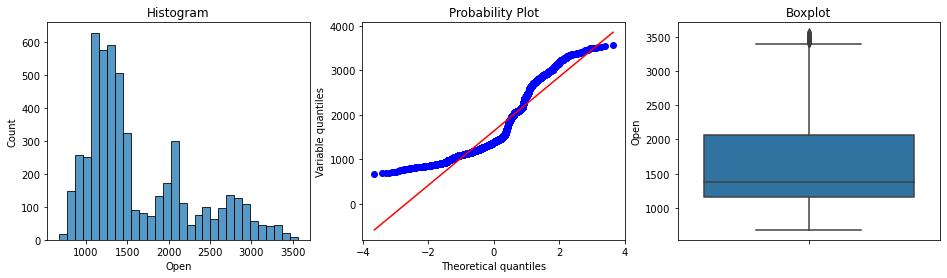

In [5]:
outlier_detection_plots(data, 'Open')

In [6]:
# Removing the date column and feature scaling the data
dataset = dataset.iloc[:,1:]

In [7]:
# feature scaling using standard scaler
scaler = StandardScaler()
scaler.fit(dataset)
dataset_scaled = scaler.transform(dataset)

In [8]:
dataset_scaled

array([[-0.2542315 , -0.25466775, -0.28682176, -0.27607514, -0.27607514,
        -1.47291265],
       [-0.27583624, -0.28964281, -0.35006825, -0.36198906, -0.36198906,
        -1.42199461],
       [-0.36176214, -0.3540502 , -0.38058671, -0.35784742, -0.35784742,
        -1.37153827],
       ...,
       [ 2.89672754,  2.89268445,  2.86884838,  2.85478322,  2.85478322,
         0.44563536],
       [ 2.80163917,  2.83302139,  2.80756399,  2.846577  ,  2.846577  ,
         0.36451607],
       [ 2.86289615,  2.87398413,  2.86869371,  2.8473006 ,  2.8473006 ,
         0.99653948]])

In [9]:
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns)

In [10]:
dataset_scaled

,Open,High,Low,Close,Adj Close,Volume
0,-0.254232,-0.254668,-0.286822,-0.276075,-0.276075,-1.472913
1,-0.275836,-0.289643,-0.350068,-0.361989,-0.361989,-1.421995
2,-0.361762,-0.354050,-0.380587,-0.357847,-0.357847,-1.371538
3,-0.357620,-0.356154,-0.358304,-0.355784,-0.355784,-1.367053
4,-0.355557,-0.310754,-0.344969,-0.297246,-0.297246,-1.279398
...,...,...,...,...,...,...
5227,2.872936,2.926324,2.898301,2.924916,2.924916,0.174121
5228,2.925277,2.902004,2.900232,2.890596,2.890596,0.290322
5229,2.896728,2.892684,2.868848,2.854783,2.854783,0.445635
5230,2.801639,2.833021,2.807564,2.846577,2.846577,0.364516


In [11]:
# before and after feature scaling
def diagonstic_plots(df, df1, variable1, variable2, variable3):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    # before scaling
    ax1.set_title('Before Scaling')
    sns.kdeplot(df[variable1], ax=ax1)
    sns.kdeplot(df[variable2], ax=ax1)
    sns.kdeplot(df[variable3], ax=ax1)

    # after scaling
    ax2.set_title('After Standard Scaling')
    sns.kdeplot(df1[variable1], ax=ax2)
    sns.kdeplot(df1[variable2], ax=ax2)
    sns.kdeplot(df1[variable3], ax=ax2)
    plt.show()

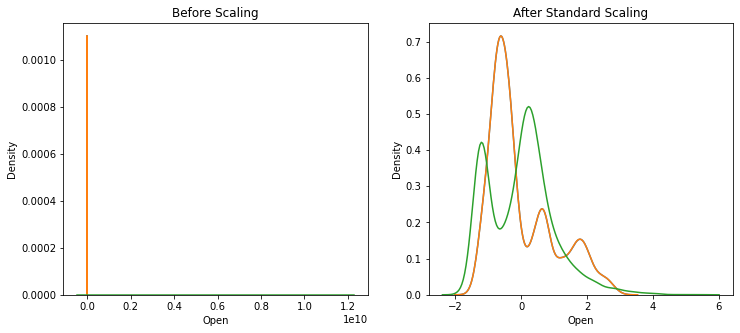

In [12]:
diagonstic_plots(dataset, dataset_scaled, 'Open', 'Close', 'Volume')

## Task 1:- Examining the volume data and getting the optimal numbers of clusters

In [13]:
# to get the perfect number of cluster
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(dataset_scaled)
    clusters = kmeans.predict(dataset_scaled)
    silhouette_avg = silhouette_score(dataset_scaled, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.504618237416401
For n_clusters = 4 The average silhouette_score is : 0.5136636746770947
For n_clusters = 5 The average silhouette_score is : 0.49449556824711516
For n_clusters = 6 The average silhouette_score is : 0.4672140816306934
For n_clusters = 7 The average silhouette_score is : 0.41931674010145803
For n_clusters = 8 The average silhouette_score is : 0.40887314801623714
For n_clusters = 9 The average silhouette_score is : 0.4154162417018694


In [14]:
# Taking 4 clusters
km1=KMeans(n_clusters=4, random_state = 0)
#Fitting the input data
km1.fit(dataset_scaled)
#predicting the labels of the input data
y=km1.predict(dataset_scaled)
#adding the labels to a column named label
dataset_scaled["label"] = y
#The new dataframe with the clustering done

In [15]:
dataset_scaled['Date'] = data['Date']

In [16]:
dataset_scaled

,Open,High,Low,Close,Adj Close,Volume,label,Date
0,-0.254232,-0.254668,-0.286822,-0.276075,-0.276075,-1.472913,1,2000-01-03
1,-0.275836,-0.289643,-0.350068,-0.361989,-0.361989,-1.421995,1,2000-01-04
2,-0.361762,-0.354050,-0.380587,-0.357847,-0.357847,-1.371538,1,2000-01-05
3,-0.357620,-0.356154,-0.358304,-0.355784,-0.355784,-1.367053,1,2000-01-06
4,-0.355557,-0.310754,-0.344969,-0.297246,-0.297246,-1.279398,1,2000-01-07
...,...,...,...,...,...,...,...,...
5227,2.872936,2.926324,2.898301,2.924916,2.924916,0.174121,2,2020-10-12
5228,2.925277,2.902004,2.900232,2.890596,2.890596,0.290322,2,2020-10-13
5229,2.896728,2.892684,2.868848,2.854783,2.854783,0.445635,2,2020-10-14
5230,2.801639,2.833021,2.807564,2.846577,2.846577,0.364516,2,2020-10-15


In [17]:
dataset['label'] = dataset_scaled['label'].values

In [18]:
dataset.to_csv('file1.csv')

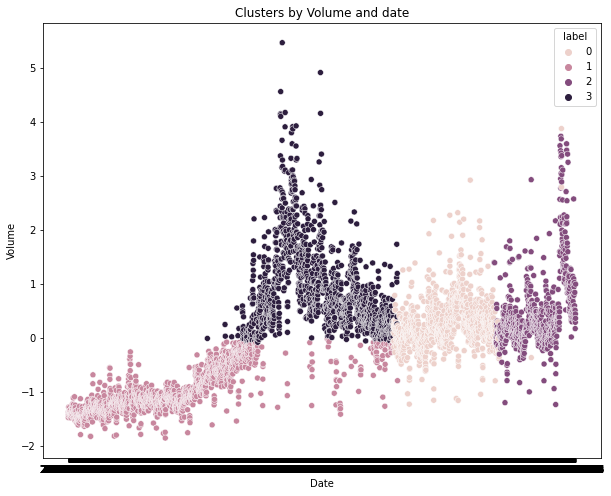

In [19]:
x_axis = dataset_scaled['Date']
y_axis = dataset_scaled['Volume']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = dataset_scaled['label'])
plt.title('Clusters by Volume and date')
plt.show()

In [20]:
pd.Series(y).value_counts()

1    1965
3    1396
0    1067
2     804
dtype: int64

## Task 2

In [21]:
# difference of opening price = [Opening price (today) / Opening price (yesterday)] - 1
n_steps = 2
def my_fun(x):
    return ((x.iloc[-1]/x.iloc[0])-1)

data['Parameter_1']= (data['Open'].rolling(window=n_steps).apply(my_fun))

In [22]:
# differnce of opening price and closing price = [Opening price (today) - Closing price (today)]/Closing price(today)
def my_func_parameter_2(df,variable,variable1):
    return ((df[variable]-df[variable1])/df[variable1])
data['Parameter_2']= my_func_parameter_2(data,'Open','Close')

In [23]:
# difference of volume = [Volume (today) / Volume (yesterday)] - 1
data['Parameter_3']= (data['Volume'].rolling(window=n_steps).apply(my_fun))

In [24]:
data = data.iloc[1:, :]

In [25]:
new_data = data.iloc[:,7:]

In [26]:
new_data

,Parameter_1,Parameter_2,Parameter_3
1,-0.009549,0.039874,0.082850
2,-0.038345,-0.001918,0.075818
3,0.001922,-0.000955,0.006264
4,0.000956,-0.026376,0.121670
5,0.027090,-0.011066,-0.130917
...,...,...,...
5227,0.011663,-0.009677,-0.129495
5228,0.009711,0.006287,0.051380
5229,-0.005246,0.007682,0.065318
5230,-0.017565,-0.008503,-0.032023


In [27]:
scaler = StandardScaler()
scaler.fit(new_data)
new_data_scaled = scaler.transform(new_data)

In [28]:
new_data_scaled = pd.DataFrame(new_data_scaled, columns=new_data.columns)

In [29]:
new_data_scaled.head()

,Parameter_1,Parameter_2,Parameter_3
0,-0.836239,3.447063,0.309502
1,-3.297586,-0.162481,0.275779
2,0.144289,-0.079244,-0.057743
3,0.061675,-2.274840,0.495649
4,2.295583,-0.952554,-0.715556


In [30]:
new_data_scaled.describe()

,Parameter_1,Parameter_2,Parameter_3
count,5.231000e+03,5.231000e+03,5.231000e+03
mean,-9.338523e-18,1.563672e-17,7.555714e-18
std,1.000096e+00,1.000096e+00,1.000096e+00
min,-7.466637e+00,-8.407689e+00,-3.737667e+00
25%,-4.165869e-01,-4.510093e-01,-4.738775e-01
50%,4.108529e-02,-4.221107e-02,-9.293193e-02
75%,4.551916e-01,3.941385e-01,3.584872e-01
max,9.101378e+00,8.257286e+00,1.542278e+01


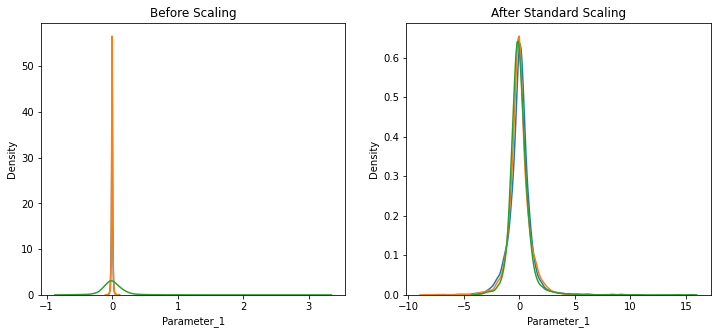

In [31]:
diagonstic_plots(new_data, new_data_scaled, 'Parameter_1', 'Parameter_2', 'Parameter_3')

In [32]:
# Taking 4 clusters
km1=KMeans(n_clusters=4, random_state = 0)
#Fitting the input data
km1.fit(new_data_scaled)
#predicting the labels of the input data
y=km1.predict(new_data_scaled)
#adding the labels to a column named label
new_data_scaled["label"] = y
#The new dataframe with the clustering done
new_data_scaled.head()

,Parameter_1,Parameter_2,Parameter_3,label
0,-0.836239,3.447063,0.309502,0
1,-3.297586,-0.162481,0.275779,3
2,0.144289,-0.079244,-0.057743,1
3,0.061675,-2.274840,0.495649,3
4,2.295583,-0.952554,-0.715556,1


In [33]:
new_data_scaled['Date'] = data['Date']
new_data_scaled

,Parameter_1,Parameter_2,Parameter_3,label,Date
0,-0.836239,3.447063,0.309502,0,NaN
1,-3.297586,-0.162481,0.275779,3,2000-01-04
2,0.144289,-0.079244,-0.057743,1,2000-01-05
3,0.061675,-2.274840,0.495649,3,2000-01-06
4,2.295583,-0.952554,-0.715556,1,2000-01-07
...,...,...,...,...,...
5226,0.976900,-0.832558,-0.708737,1,2020-10-09
5227,0.810082,0.546234,0.158595,1,2020-10-12
5228,-0.468438,0.666707,0.225429,0,2020-10-13
5229,-1.521429,-0.731210,-0.241340,3,2020-10-14


In [34]:
pd.Series(y).value_counts()

1    2809
3    1314
0    1003
2     105
dtype: int64

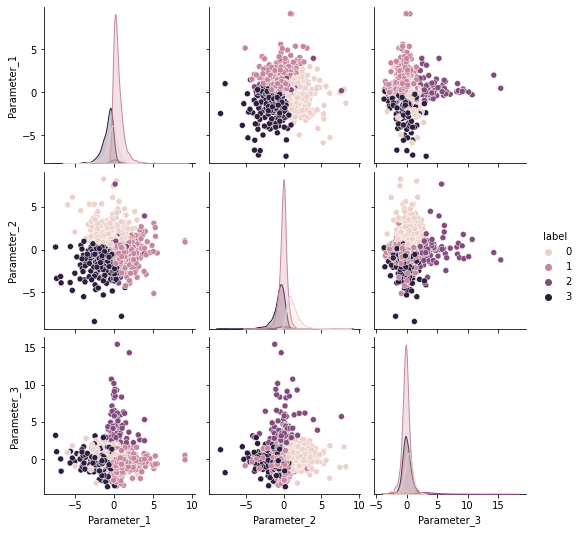

In [35]:
sns.pairplot(new_data_scaled,hue='label')

In [36]:
data['label'] = new_data_scaled['label']

In [37]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Parameter_1,Parameter_2,Parameter_3,label
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-0.009549,0.039874,0.082850,3.0
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,-0.038345,-0.001918,0.075818,1.0
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,0.001922,-0.000955,0.006264,3.0
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.000956,-0.026376,0.121670,1.0
5,2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000,0.027090,-0.011066,-0.130917,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5227,2020-10-12,3500.020020,3549.850098,3499.610107,3534.219971,3534.219971,3428970000,0.011663,-0.009677,-0.129495,1.0
5228,2020-10-13,3534.010010,3534.010010,3500.860107,3511.929932,3511.929932,3605150000,0.009711,0.006287,0.051380,0.0
5229,2020-10-14,3515.469971,3527.939941,3480.550049,3488.669922,3488.669922,3840630000,-0.005246,0.007682,0.065318,3.0
5230,2020-10-15,3453.719971,3489.080078,3440.889893,3483.340088,3483.340088,3717640000,-0.017565,-0.008503,-0.032023,1.0


In [38]:
data.to_csv('file2.csv')

## Task 3

In [39]:
## to make date as an index
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231 entries, 1 to 5231
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5231 non-null   datetime64[ns]
 1   Open         5231 non-null   float64       
 2   High         5231 non-null   float64       
 3   Low          5231 non-null   float64       
 4   Close        5231 non-null   float64       
 5   Adj Close    5231 non-null   float64       
 6   Volume       5231 non-null   int64         
 7   Parameter_1  5231 non-null   float64       
 8   Parameter_2  5231 non-null   float64       
 9   Parameter_3  5231 non-null   float64       
 10  label        5230 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 449.7 KB


In [40]:
data.set_index('Date', inplace=True)
data

,Open,High,Low,Close,Adj Close,Volume,Parameter_1,Parameter_2,Parameter_3,label
Date,,,,,,,,,,
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-0.009549,0.039874,0.082850,3.0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,-0.038345,-0.001918,0.075818,1.0
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,0.001922,-0.000955,0.006264,3.0
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.000956,-0.026376,0.121670,1.0
2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000,0.027090,-0.011066,-0.130917,1.0
...,...,...,...,...,...,...,...,...,...,...
2020-10-12,3500.020020,3549.850098,3499.610107,3534.219971,3534.219971,3428970000,0.011663,-0.009677,-0.129495,1.0
2020-10-13,3534.010010,3534.010010,3500.860107,3511.929932,3511.929932,3605150000,0.009711,0.006287,0.051380,0.0
2020-10-14,3515.469971,3527.939941,3480.550049,3488.669922,3488.669922,3840630000,-0.005246,0.007682,0.065318,3.0


In [56]:
n_steps = 2
def my_fun1(x):
    return ((x.iloc[-1]/x.iloc[0])-1)

In [57]:
# Monthly returns = [Closing price (last day) / Closing price (first day)] - 1
data['Monthly Returns'] = (data['Close'].resample('BM').apply(my_fun1))

In [58]:
data

,Open,High,Low,Close,Adj Close,Volume,Parameter_1,Parameter_2,Parameter_3,label,Monthly Returns,Parameter_adj_close,class_label
Date,,,,,,,,,,,,,
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-0.009549,0.039874,0.082850,3.0,NaN,NaN,1
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,-0.038345,-0.001918,0.075818,1.0,NaN,NaN,1
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,0.001922,-0.000955,0.006264,3.0,NaN,NaN,1
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.000956,-0.026376,0.121670,1.0,NaN,NaN,1
2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000,0.027090,-0.011066,-0.130917,1.0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-12,3500.020020,3549.850098,3499.610107,3534.219971,3534.219971,3428970000,0.011663,-0.009677,-0.129495,1.0,NaN,33.909912,1
2020-10-13,3534.010010,3534.010010,3500.860107,3511.929932,3511.929932,3605150000,0.009711,0.006287,0.051380,0.0,NaN,-14.719970,0
2020-10-14,3515.469971,3527.939941,3480.550049,3488.669922,3488.669922,3840630000,-0.005246,0.007682,0.065318,3.0,NaN,-92.170166,0


In [59]:
data.to_csv('file_2.csv')

In [43]:
# function to find the profit
def func_adj_close(x):
    return ((x.iloc[-1] - x.iloc[0]))
data['Parameter_adj_close']= (data['Adj Close'].rolling(window=30).apply(func_adj_close))

In [44]:
data['class_label'] = np.where(data.Parameter_adj_close < 0, 0, 1)

In [45]:
data['Parameter_adj_close'].isnull().mean()

0.005543873064423628

In [46]:
cols = ['Open','High', 'Low','Close','Adj Close','Parameter_adj_close','class_label']
data_algo = pd.DataFrame(data, columns = cols)

In [47]:
data_algo = data_algo.dropna()

In [48]:
data_algo

,Open,High,Low,Close,Adj Close,Parameter_adj_close,class_label
Date,,,,,,,
2000-02-15,1389.939941,1407.719971,1376.250000,1402.050049,1402.050049,2.630005,1
2000-02-16,1402.050049,1404.550049,1385.579956,1387.670044,1387.670044,-14.439941,0
2000-02-17,1387.670044,1399.880005,1380.069946,1388.260010,1388.260010,-15.189941,0
2000-02-18,1388.260010,1388.589966,1345.319946,1346.089966,1346.089966,-95.380005,0
2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,-105.429932,0
...,...,...,...,...,...,...,...
2020-10-12,3500.020020,3549.850098,3499.610107,3534.219971,3534.219971,33.909912,1
2020-10-13,3534.010010,3534.010010,3500.860107,3511.929932,3511.929932,-14.719970,0
2020-10-14,3515.469971,3527.939941,3480.550049,3488.669922,3488.669922,-92.170166,0


## decision tree to classify if investing in any month can be a profitable strategy

In [49]:
columns = ['Open','High','Low','Close','Adj Close','Parameter_adj_close']
X = data_algo[columns]
y = data_algo['class_label']

In [50]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)

In [51]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Accuracy: {:.2f} %".format(100*metrics.accuracy_score(Y, self.predictions)))
        print("Precision: {:.2f} %".format(100*metrics.precision_score(Y, self.predictions)))
        print("Recall: {:.2f} %".format(100*metrics.recall_score(Y, self.predictions)))
        print("F1 score: {:.2f} %".format(100*metrics.f1_score(Y, self.predictions)))
        print("Confusion Matrix: ", metrics.confusion_matrix(Y, self.predictions))

In [52]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Accuracy: 99.49 %
Precision: 99.90 %
Recall: 99.30 %
F1 score: 99.60 %
Confusion Matrix:  [[555   1]
 [  7 998]]
